In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

import gm2
import trfp
import plotting_functions as plt2
import analysis_helper as helper
import helper_function_candidates as helper_old

Welcome to JupyROOT 6.12/04


In [2]:
moment_df = helper.calc_moment_df(helper.root_to_pandas([3956], prefix='v9_20_00/FieldPlainRootOutput_', tr_run=True))

Reading event 8780/8781 99.99%          
loop done: 100%                                    
Reading event 2630/2634 99.85%    
loop done: 100%                                    
Finished calculating all moments for 4386 events.


In [7]:
def trolley_footprint_replacement(tr_moment_df, veto_extent=25):
    no_mask_df = tr_moment_df.copy()
    t0 = no_mask_df.index.values[0]
    no_mask_df.index -= t0
    index = no_mask_df.index.values

    for st in range(72):
        print '\rRemoving trolley image from station '+str(st)+'.',

        # veto when trolley is close to station

        veto_low = (trfp.STATION_BARCODE_PHI[st]-1.5-veto_extent/2)%360
        veto_high = (trfp.STATION_BARCODE_PHI[st]-1.5+veto_extent/2)%360
        if veto_low < veto_high:
            veto_mask = (no_mask_df['tr_phi']>veto_low) & (no_mask_df['tr_phi']<veto_high)
        else:  # this happens when wrapping around 360 deg
            veto_mask = (no_mask_df['tr_phi']>veto_low) | (no_mask_df['tr_phi']<veto_high)

        for m in range(6):

            stm = 'st'+str(st)+',m'+str(m+1)

            # calculate local drift

            times = no_mask_df.index.values[~veto_mask]
            freqs = no_mask_df[stm][~veto_mask]

            local_drift_fit = np.polyfit(times, freqs, 5)
            local_drift = np.polyval(local_drift_fit, no_mask_df.index.values)

            # need to average other side of ring
            all_good_stations = np.arange(6,72)  # not using the inflector stations
            no_ground_loop_stations = np.array(range(6,16)+range(64,72))  # vaid for 25 deg veto

            # next need to average all good stations that are not within 3 of current station
            if st not in range(16, 23):  # note that these ranged were chosen for 25 deg veto
                averaging_stations = np.delete(all_good_stations,
                                               np.argwhere((np.abs((all_good_stations - st)%72)<=3)
                                                          | (np.abs((all_good_stations - st)%72)>=69))
                                              )
            else:
                averaging_stations = np.delete(no_ground_loop_stations,
                                               np.argwhere((np.abs((no_ground_loop_stations - st)%72)<=3)
                                                          | (np.abs((no_ground_loop_stations - st)%72)>=69))
                                              )
            avg_stms = ['st'+str(avg_st)+',m'+str(m+1) for avg_st in averaging_stations]
            replacement = no_mask_df[avg_stms].mean(axis=1)

            # calculate global drift
            global_drift_fit = np.polyfit(index[veto_mask], replacement[veto_mask], 1)
            global_drift = np.polyval(global_drift_fit, index[veto_mask])

            # subtract global drift from replacement
            replacement = replacement[veto_mask] - global_drift

            # add local drift
            replacement = replacement + local_drift[veto_mask]

            no_mask_df[stm][veto_mask] = replacement

    no_mask_df.index += t0
    return no_mask_df

In [8]:
no_mask_df = trolley_footprint_replacement(moment_df)

Removing trolley image from station 71.              


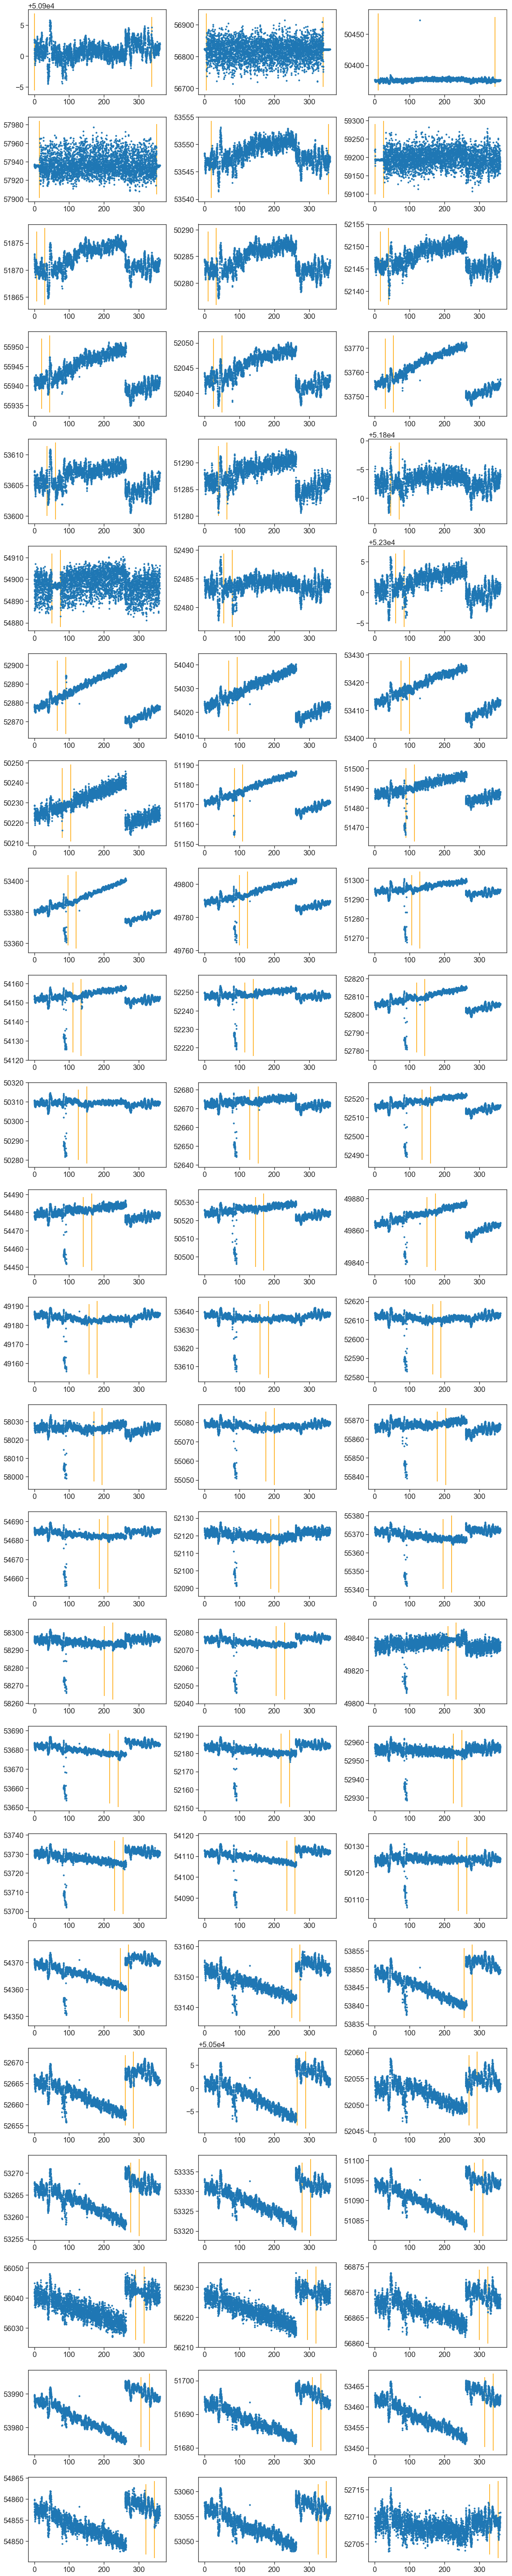

In [9]:
fig, axs = plt.subplots(24,3)

for i in range(24):
    for j in range(3):
        plt.sca(axs[i,j])
        st = i*3 + j
        
        veto_low = (trfp.STATION_BARCODE_PHI[st]-1.5-25/2)%360
        veto_high = (trfp.STATION_BARCODE_PHI[st]-1.5+25/2)%360
        
        plt.plot(no_mask_df['tr_phi'], no_mask_df['st'+str(st)+',m1'], '.')
        plt.vlines(veto_low, plt.ylim()[0], plt.ylim()[1], color='orange')
        plt.vlines(veto_high, plt.ylim()[0], plt.ylim()[1], color='orange')
        
fig.set_size_inches(16, 80)
fig.tight_layout()

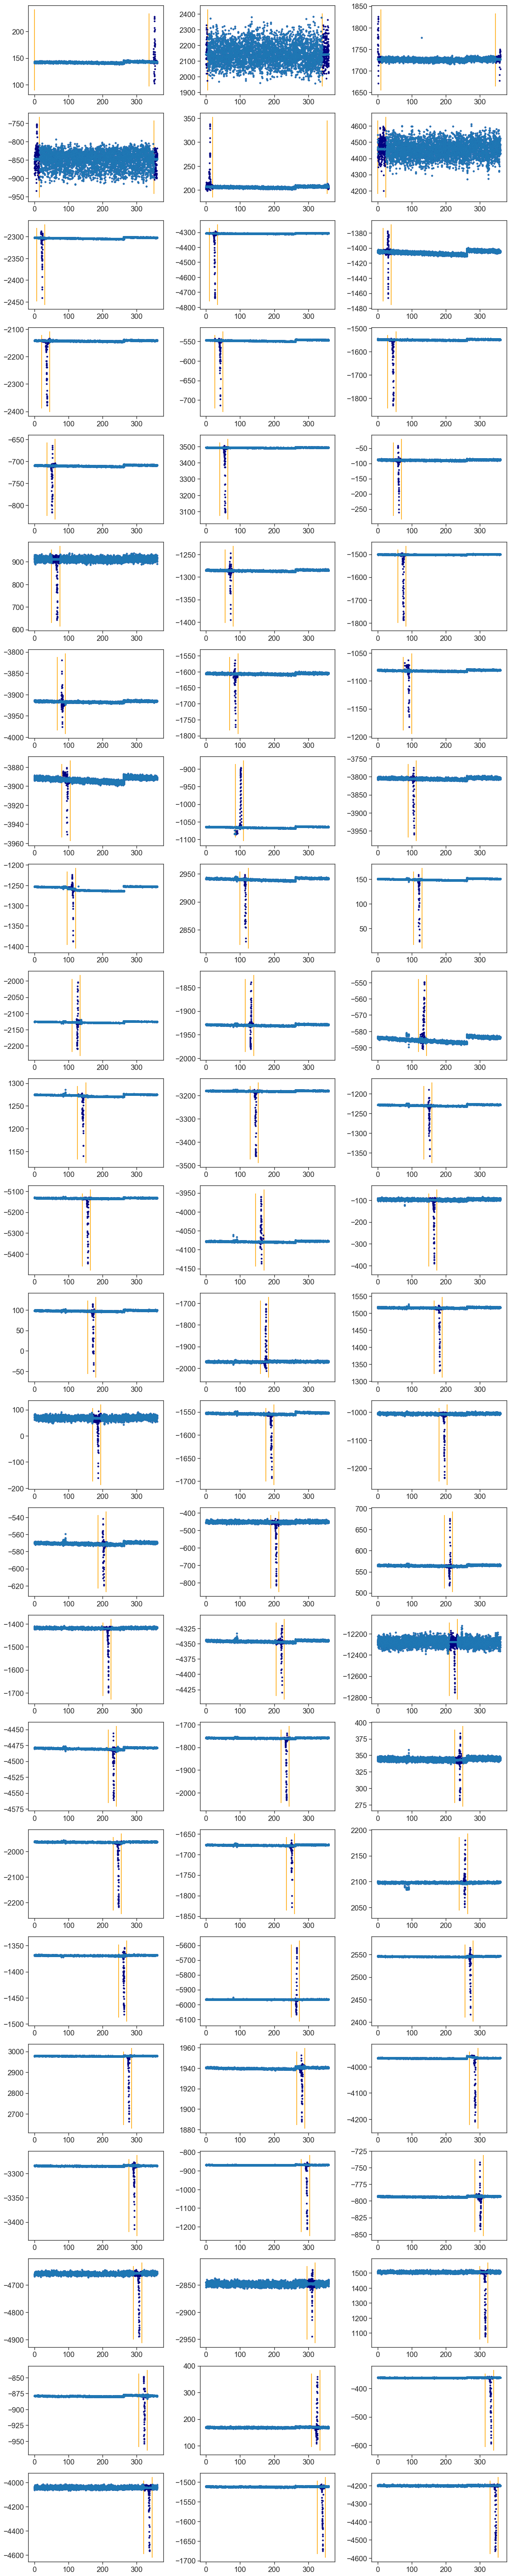

In [17]:
fig, axs = plt.subplots(24,3)

for i in range(24):
    for j in range(3):
        plt.sca(axs[i,j])
        st = i*3 + j
        
        veto_low = (trfp.STATION_BARCODE_PHI[st]-1.5-25/2)%360
        veto_high = (trfp.STATION_BARCODE_PHI[st]-1.5+25/2)%360
        
        plt.plot(moment_df['tr_phi'], moment_df['st'+str(st)+',m2'], '.', color='navy')
        plt.plot(no_mask_df['tr_phi'], no_mask_df['st'+str(st)+',m2'], '.')
        plt.vlines(veto_low, plt.ylim()[0], plt.ylim()[1], color='orange')
        plt.vlines(veto_high, plt.ylim()[0], plt.ylim()[1], color='orange')
        
fig.set_size_inches(16, 80)
fig.tight_layout()

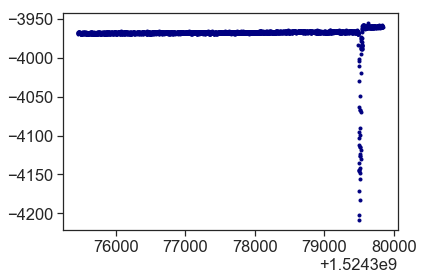

In [24]:
plt.plot(moment_df.index, moment_df['st59,m2'], '.', color='navy')